# Libraries

In [81]:
import numpy as np
import pandas as pd
import os, sys
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, mean_squared_error, mean_absolute_error, f1_score
from tqdm import tqdm

from multiprocessing import Pool, cpu_count
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet import Prophet

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')

sys.path.append('/analysis/script/')
from wrmsse_evaluator import WRMSSEEvaluator

import warnings
warnings.filterwarnings('ignore')

# Load data

In [3]:
input_dir = '../input/'
df_sale = pd.read_csv(input_dir + 'sales_train_validation.csv')
df_calendar = pd.read_csv(input_dir + 'calendar.csv')
df_price = pd.read_csv(input_dir + 'sell_prices.csv')

In [4]:
print(df_sale.shape)
df_sale.head()

(30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [5]:
print(df_calendar.shape)
df_calendar.head()

(1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [6]:
print(df_price.shape)
df_price.head()

(6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# evaluation data

In [38]:
df_eval = pd.read_csv(input_dir + 'sales_train_evaluation.csv')
print(df_eval.shape)
df_eval.head()

(30490, 1947)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [ ]:
# evaluator
evaluator = WRMSSEEvaluator(df_eval.iloc[:, :-28], df_eval.iloc[:, -28:], df_calendar, df_price)

def get_LBscore(preds_valid):
    groups, scores = evaluator.score(preds_valid)
    for i in range(len(groups)):
        print(f"Score for group {groups[i]}: {round(scores[i], 5)}")
    print('*'*50)
    print(f"\nPublic LB Score: {round(score_public_lb, 5)}")
    print('*'*50)

# Make timeseries

In [ ]:
columns = df_sale.columns
date_columns = columns[columns.str.contains("d_")]
dates_s = [pd.to_datetime(df_calendar.loc[df_calendar['d'] == str_date,'date'].values[0]) for str_date in date_columns]


tmp = df_sale[date_columns].sum()
ignore_date = df_calendar[df_calendar['d'].isin(tmp[tmp < 10000].index.values)]['date'].values

df_ev_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': df_calendar[~df_calendar['event_name_1'].isna()]['date']})
df_ev_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': df_calendar[~df_calendar['event_name_2'].isna()]['date']})
df_ev_3 = pd.DataFrame({'holiday': 'snap_CA', 'ds': df_calendar[df_calendar['snap_CA'] == 1]['date']})
df_ev_4 = pd.DataFrame({'holiday': 'snap_TX', 'ds': df_calendar[df_calendar['snap_TX'] == 1]['date']})
df_ev_5 = pd.DataFrame({'holiday': 'snap_WI', 'ds': df_calendar[df_calendar['snap_WI'] == 1]['date']})
holidays = pd.concat((df_ev_1, df_ev_2, df_ev_3, df_ev_4, df_ev_5))

In [70]:
def CreateTimeSeries(df, id):
    item_series = df[df['id'] == id]
    columns = df.columns
    date_columns = columns[columns.str.contains("d_")]
    dates_s = [pd.to_datetime(df_calendar.loc[df_calendar['d'] == str_date,'date'].values[0]) for str_date in date_columns]
    dates = pd.DataFrame({'ds': dates_s}, index=range(len(dates_s)))
    dates['y'] = item_series[date_columns].values.transpose()
    # Remove chirstmas date
    #dates = dates[~dates['ds'].isin(ignore_date)]
    # Remove zero day
    #dates = dates[dates['y'] > 0]        
    return dates
    
def run_prophet(timeseries, holidays=None, add_country_holiday=True):
    # given holidays
    if holidays is not None:
        model = Prophet(uncertainty_samples=False, holidays=holidays)
    else:
        model = Prophet(uncertainty_samples=False)
        
    # country holidays
    if add_country_holiday:
        model.add_country_holidays(country_name='US')
    
    # fit and predict
    model.fit(timeseries)
    forecast = model.make_future_dataframe(periods=28, include_history=False)
    forecast = model.predict(forecast)
    return forecast['yhat'].values.transpose()

def run_statsmodel(timeseries, model='Holt'):
    if model == 'SimpleExpSmoothing':
        fitted = SimpleExpSmoothing(timeseries['y'].values).fit()
    elif model == 'Holt':
        fitted = Holt(timeseries['y'].values).fit()
    return fitted.forecast(28)

# Example

In [51]:
# example
id = 'HOBBIES_1_004_CA_1_validation'
dates = CreateTimeSeries(df_sale, id)
id = 'HOBBIES_1_004_CA_1_evaluation'
dates_eval = CreateTimeSeries(df_eval, id)

In [52]:
print(dates.shape)
dates.head()

(1913, 2)


,ds,y
0,2011-01-29,0
1,2011-01-30,0
2,2011-01-31,0
3,2011-02-01,0
4,2011-02-02,0


In [53]:
print(dates_eval.shape)
dates_eval.head()

(1941, 2)


,ds,y
0,2011-01-29,0
1,2011-01-30,0
2,2011-01-31,0
3,2011-02-01,0
4,2011-02-02,0


In [71]:
# predict
pred_all = run_prophet(dates, holidays=holidays, add_country_holiday=True)
pred_cout = run_prophet(dates, holidays=holidays, add_country_holiday=False)
pred_no = run_prophet(dates, holidays=None, add_country_holiday=False)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [72]:
pred_holt = run_statsmodel(dates, model='Holt')
pred_exp = run_statsmodel(dates, model='SimpleExpSmoothing')

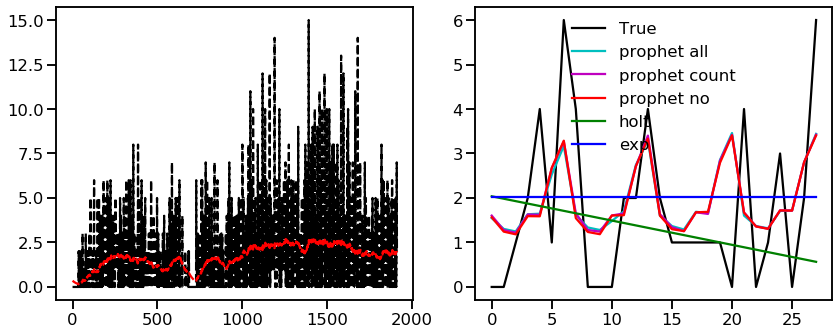

In [75]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
ax = ax.flatten()

# train data
ax[0].plot(np.arange(len(dates)), dates['y'].values, 'k--')
ax[0].plot(np.arange(len(dates)), dates_exp['y'].values, 'r--')

# predictions
ax[1].plot(np.arange(28), dates_eval['y'].iloc[-28:], 'k', label='True')
ax[1].plot(np.arange(28), pred_all, 'c', label='prophet all')
ax[1].plot(np.arange(28), pred_cout, 'm', label='prophet count')
ax[1].plot(np.arange(28), pred_no, 'r', label='prophet no')
ax[1].plot(np.arange(28), pred_holt, 'g', label='holt')
ax[1].plot(np.arange(28), pred_exp, 'b', label='exp')
ax[1].legend(frameon=False)
fig.tight_layout()

# Fitting

In [ ]:
print(f'Parallelism on {cpu_count()} CPU')
with Pool(cpu_count()) as p:
    predictions1  = list(p.map(run_prophet, ids1))